In [1]:
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt

import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.norm as norm
from scipy.stats import norm as normsp

from autograd import grad, elementwise_grad
from autograd.core import primitive

from autograd.util import flatten


from autograd.optimizers import adam

In [2]:
%matplotlib inline

In [3]:
def sum_log_mixtureModel(z, params):
    [c1, m1, m2, s1, s2] = params
    return -np.sum(1E-6+np.log(c1*norm.pdf(z,m1,s1)+(1.-c1)*norm.pdf(z,m2,s2)))

In [4]:
def mixtureModel(z, params):
    [c1, m1, m2, s1, s2] = params
    return (c1*norm.pdf(z,m1,s1)+(1-c1)*norm.pdf(z,m2,s2))

In [104]:
def finv(z, params):
    #[c1, m1, m2, s1, s2] = params
    #return (c1*norm.cdf(x,m1,s1)+(1-c1)*norm.cdf(x,m2,s2))
    #return (params[0]*norm.cdf(z,params[1],params[3])+(1-params[0])*norm.cdf(z,params[2],params[4]))
    p1 = params[1:4:2]    
    p2 = params[2:5:2]
    zz = finv_internal(z,p1)
    return finv_internal(zz,p2)

In [106]:
def finv_internal(z_temp,params_temp):
    return norm.cdf(z_temp,params_temp[0],params_temp[1])

In [6]:
def f(v, params):
    #not sure what f is 
    return Null

In [7]:
def get_J(params):                   # A wrapper for broadcasting
    return grad(lambda z: np.sum(finv(z,params)))

In [8]:
def density_from_finv(z,params):
    J = grad(finv)
    ret = np.zeros(z.size)
    for i, zz in enumerate(z):
        ret[i]=np.abs(J(zz,params))
    return ret

In [9]:
def sum_log_density_from_finv(z, params):
    return -np.sum(1E-6 + np.log(get_J(params)(z)))

In [10]:
@primitive
def sample_model(params,N=100):
    #not differentiable w.r.t. params
    copy_params = params.tolist()
    [c1, m1, m2, s1, s2] = copy_params
    #n1 = npr.binomial(N,c1)
    #n2=N-n1
    n1 = np.floor(N*c1)
    n2=N-n1
    z1 = npr.normal(m1,s1,n1)
    z2 = npr.normal(m2,s2,n2)
    z=np.hstack((z1,z2))
    npr.shuffle(z)
    return z

In [12]:
def folding_density(x,z):
    return norm.pdf(x,z+1,0.02+.2*np.abs(z))

In [ ]:
def sample_folding_z(z):
    return npr.normal(z+1,0.02+.2*np.abs(z))

In [11]:
def sample_folding_z(z):
    return npr.normal(z+1,0.02+.2*np.abs(z))

In [13]:
def sample_folded_z(params, N=100):
    return sample_folding(sample_model(params,N))

In [14]:
def folded_density_z(x,params,M=100):
    temp_z = sample_model(params,M)
    return np.sum(np.reshape(folding_density(np.repeat(x,M),np.tile(temp_z,x.size)),(x.size,M)),axis=1)/M

In [ ]:
def folded_density(M=100):
    v = npr.uniform(M)
    
    def eval(x,params, update=False):
        if update:
            print("current samples {}".format(samples))
            nonlocal v 
            v = npr.uniform(M)
            print("new samples {}".format(samples))
        return np.sum(norm.pdf(np.ravel(np.tile(samples, p.size)),np.repeat(p,samples.size),np.repeat(1., p.size*samples.size)).reshape(p.size,samples.size),axis=1)
    
    return eval

In [15]:
def sum_log_folded_density_from_finv(x, params):
    return -np.sum(1E-6 + np.log(folded_density(x,params)))

In [23]:
true_params = np.array([.5,-.5,.5,.1,.2])

In [96]:
true_params[2:5:2]

array([ 0.5,  0.2])

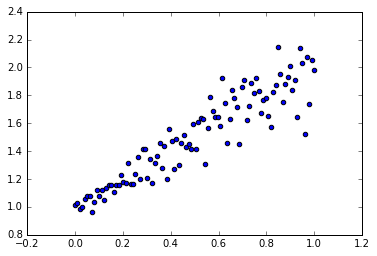

In [24]:
z_test = np.linspace(0,1,100)
x_test = sample_folding(z_test)
plt.scatter(z_test,x_test)

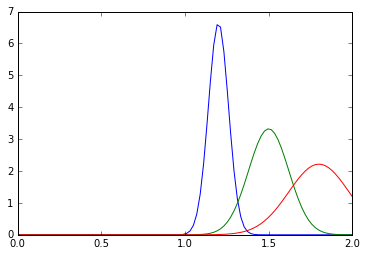

In [25]:
plt.plot(np.linspace(0,2,100),folding_density(np.linspace(0,2,100),.2+0*z_test))
plt.plot(np.linspace(0,2,100),folding_density(np.linspace(0,2,100),.5+0*z_test))
plt.plot(np.linspace(0,2,100),folding_density(np.linspace(0,2,100),.8+0*z_test))

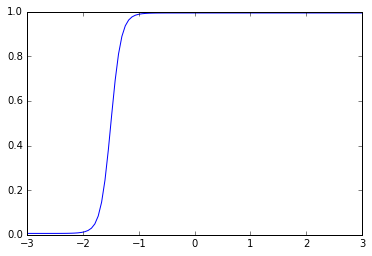

In [107]:
plt.plot(np.linspace(-3,3,100),finv(np.linspace(-1,1,100),true_params))

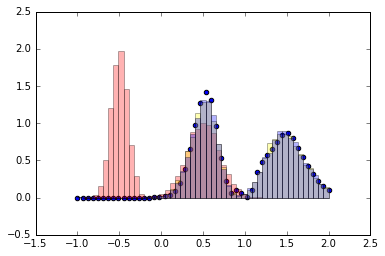

In [27]:
bins=np.linspace(-1,2,50)
_ = plt.hist(sample_model(true_params,10000), bins=bins, alpha=0.3, color='red', normed=True)
_ = plt.hist(sample_folding(sample_model(true_params,10000)), bins=bins, alpha=0.3,color='yellow', normed=True)
_ = plt.hist(sample_folded(true_params,10000), bins=bins, alpha=0.3,color='blue', normed=True)
plt.scatter(bins, folded_density(bins,true_params))

In [28]:
sum_log_folded_density_from_finv(bins,true_params)

337.46101669613904

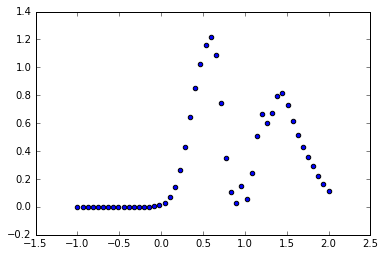

In [29]:
plt.scatter(bins, folded_density(bins,true_params))

In [30]:
dummy_data = sample_model(true_params,10000)

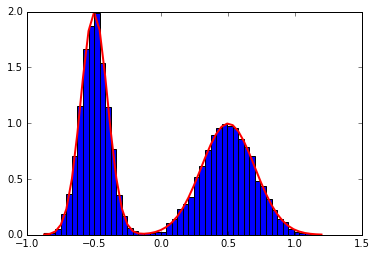

In [31]:
counts, bins, patches = plt.hist(dummy_data,50, normed=True)
plt.plot(bins,get_J(true_params)(bins), c='r', lw=2)

In [32]:
sum_log_mixtureModel(dummy_data,true_params), sum_log_density_from_finv(dummy_data,true_params)

(1613.2243087830748, 1613.2243087830748)

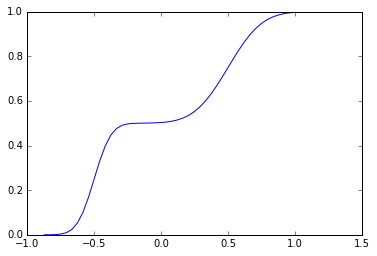

In [33]:
plt.plot(bins,finv(bins,true_params))

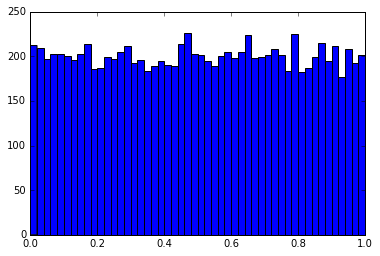

In [34]:
#check inverse
_ = plt.hist(finv(dummy_data, true_params),50)

In [35]:
def doIt():
    true_params = np.array([.8,-1,.3,.5,.2])

    init_params = np.array([.5,-1.,1., .5,.5])

    data = sample_folded(true_params,1000)
    mini_batch = 30
    
    def objective(params, t):
        npr.shuffle(data)
        penalty = 1E6*np.maximum(0,(np.abs(params[0]-.5)-0.5))
        return sum_log_folded_density_from_finv(data[0:mini_batch], params)+penalty
        #return sum_log_density_from_finv(data[0:mini_batch], params)+penalty
        #return sum_log_mixtureModel(data[0:mini_batch], params)+penalty

    print(grad(objective)(init_params, 0))

    # Set up figure.
    fig = plt.figure(figsize=(12,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=True)
    plt.show(block=False)

    x_test = np.linspace(-3,3,300)
    y_true_test = mixtureModel(x_test,true_params)

    def callback(params, t, g):
        print("Iteration {} log likelihood {} params {}".format(t, -objective(params, t),params))
        print("penalty is {}".format(1E6*np.maximum(0,np.abs(params[0]-.5)-0.5)))

        y_test = mixtureModel(x_test,params)
        
        # Plot data and functions.
        plt.cla()
        ax.plot(x_test,y_test)
        ax.plot(x_test,y_true_test)
        _ = ax.hist(data, 50, normed=True)

        plt.ylim(0,0.5/np.min(true_params[3:]))
        plt.xlim(-3,3)

        plt.draw()
        plt.pause(1.0/60.0)

    print("Optimizing network parameters...")
    optimized_params = adam(grad(objective), init_params,
                            step_size=0.01, num_iters=1000, callback=callback)

In [36]:
doIt()

NotImplementedError: Gradient of sample_model not yet implemented.

## trying various things to get autograd to ignore the sampling and calculate derivative of rest of function

In [77]:
from autograd.core import primitive
@primitive
def dummy_fun(p):
    #return np.array([.4,.5,.6]) #this is ok
    pp = npr.binomial(10000,p)
    pp = 100
    #return npr.normal(p,1,pp) #this is not
    return npr.uniform(0,1,pp) #this is not

def dummy_mean(p):
    samples = dummy_fun(p)
    return np.sum(norm.pdf(samples,p,1.))

def dummy_fun_man_grad(g, ans, vs, gvs, x):
    return 0.;

dummy_fun.defvjp(dummy_fun_man_grad)

In [78]:
dummy_mean(.501)

38.409521906450813

In [79]:
grad_dummy_mean = grad(dummy_mean)
grad_dummy_mean(0.5)

array(0.47453121371301077)

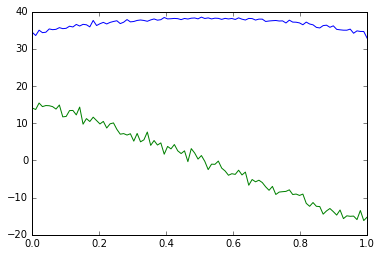

In [80]:
p_test = np.linspace(0,1,100)
mean_p_test = np.linspace(-1,1,100)
mean_p_d_test = np.linspace(-1,1,100)


for i,pp in enumerate(p_test):
    mean_p_test[i] = dummy_mean(pp)
    mean_p_d_test[i] = grad_dummy_mean(pp)
plt.plot(p_test,mean_p_test)
plt.plot(p_test,mean_p_d_test)

In [81]:
def super_dummy(p):
    return norm.pdf(np.repeat(.5,p.size),p,np.repeat(1.,p.size))

super_grad = elementwise_grad(super_dummy)

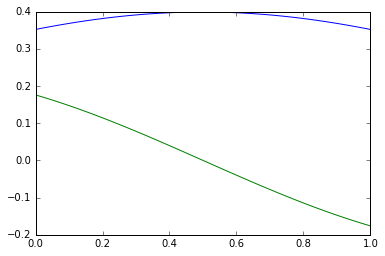

In [58]:
plt.plot(p_test,super_dummy(p_test))
plt.plot(p_test,super_grad(p_test))

In [271]:
def recursive_map(x,params):
    x0 = params[0]
    y0 = params[1]
    #print("x0 = {}, y0 = {}".format(x0,y0))
    a = (y0-x0)/(x0*x0-x0)
    b = 1-a
    xx = np.power(x,params[2])
    z = a*xx*xx+b*xx

    if params.size ==3:
        return z
    else:
        return recursive_map(z,params[3:])

In [272]:
rec_params = npr.uniform(-2,2,2)
rec_params

array([-0.16011273,  1.0859941 ])

[ 0.36609367  0.32458994  0.82201904  0.61303655  0.72190483  0.92682117]


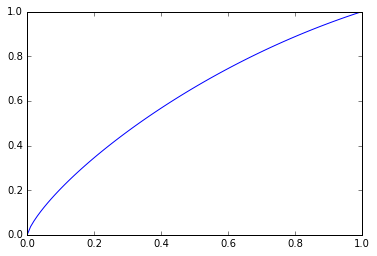

In [334]:
rec_test = np.linspace(0,1,100)

N_rec=2
x_params = npr.uniform(0,1,N_rec)
y_params = npr.uniform(x_params*x_params,2*x_params-x_params*x_params,N_rec)
a_params = npr.lognormal(0,.3,N_rec)

#rec_params =np.ravel(np.vstack((x_params.reshape(1,N_rec),y_params.reshape(1,N_rec))).T)
rec_params =np.ravel(np.vstack((x_params.reshape(1,N_rec),y_params.reshape(1,N_rec),a_params.reshape(1,N_rec))).T)

print(rec_params)

plt.plot(rec_test,recursive_map(rec_test,rec_params))

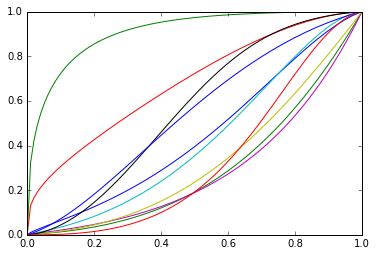

In [361]:
for i in range(10):
    N_rec=4
    x_params = npr.uniform(0,1,N_rec)
    y_params = npr.uniform(x_params*x_params,2*x_params-x_params*x_params,N_rec)
    a_params = npr.lognormal(0,.3,N_rec)
    rec_params =np.ravel(np.vstack((x_params.reshape(1,N_rec),y_params.reshape(1,N_rec),a_params.reshape(1,N_rec))).T)
    plt.plot(rec_test,recursive_map(rec_test,rec_params))

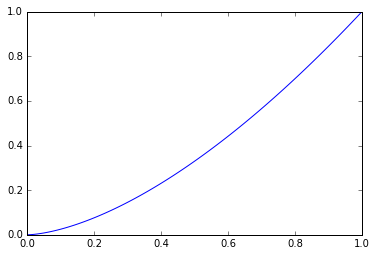

In [360]:
rec_params=np.array([.2,.04,4])
rec_params=np.array([.2,.04,4,.2,.04,.1])

plt.plot(rec_test,recursive_map(rec_test,rec_params))

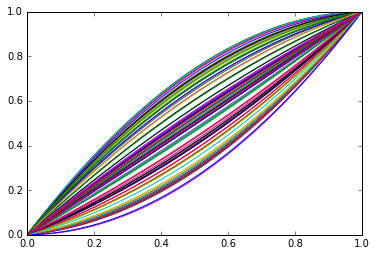

In [200]:
def simple(x,x0,y0):
    a = (y0-x0)/(x0*x0-x0)
    b = 1-a
    return a*x*x+b*x

rec_test = np.linspace(0,1,100)
y_test = npr.uniform(rec_test*rec_test,2*rec_test-rec_test*rec_test)
mask = y_test>rec_test*rec_test
xx_test = rec_test[mask]
yy_test = y_test[mask]
for i in range(80):
    plt.plot(rec_test,simple(rec_test,xx_test[i],yy_test[i]))
    

In [267]:
np.ravel(np.vstack((np.zeros(5).reshape(1,5),np.ones(5).reshape(1,5),(np.zeros(5)+3.).reshape(1,5))).T)

array([ 0.,  1.,  3.,  0.,  1.,  3.,  0.,  1.,  3.,  0.,  1.,  3.,  0.,
        1.,  3.])

In [169]:
y_test<2*rec_test-rec_test*rec_test

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

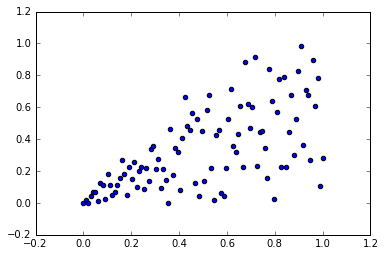

In [171]:
plt.scatter(rec_test,y_test)

In [166]:
np.maximum(x_test)

ValueError: invalid number of arguments

In [394]:
def flat_bump(x,params):
    [f,mu,sig] = params
    I = norm.cdf(1,mu,sig)-norm.cdf(0,mu,sig)
    #print(I)
    #return (1-f) + f*norm.pdf(x,mu,sig)/I #pdf
    return (1-f)*x + f*(norm.cdf(x,mu,sig)-norm.cdf(0,mu,sig))/I

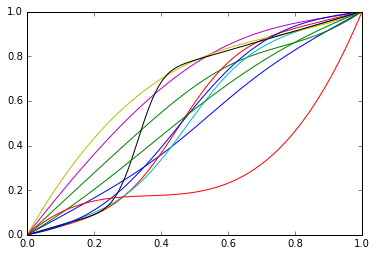

In [399]:
for i in range(10):
    mu=npr.uniform(0,1)
    sig=npr.uniform(0,1)
    I = norm.cdf(1,mu,sig)-norm.cdf(0,mu,sig)
    f=npr.uniform(1./(1-1/(np.sqrt(2*np.pi)*sig*I)),1)
    #print(f)
    params = np.array([f,mu,sig])
    x = np.linspace(0,1,100)
    plt.plot(x,flat_bump(x,params))
    plt.ylim(0,1)

In [425]:
def recursive_map(x,params):
    [f,mu,sig] = params[0:3]
    #print(params[0:3])
    I = norm.cdf(1,mu,sig)-norm.cdf(0,mu,sig)
    z = (1-f)*x + f*(norm.cdf(x,mu,sig)-norm.cdf(0,mu,sig))/I
    if params.size ==3:
        return z
    else:
        return recursive_map(z,params[3:])
    
grad_rec_map = elementwise_grad(recursive_map)

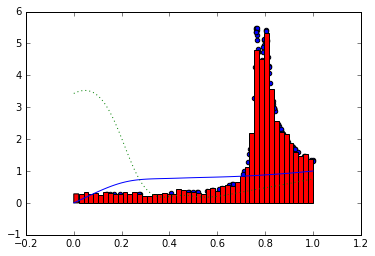

In [464]:
for i in range(1):
    N_rec=3
    mu_params = npr.uniform(0,1,N_rec)
    sig_params = npr.uniform(0.01,1,N_rec)
    I = norm.cdf(1,mu_params,sig_params)-norm.cdf(0,mu_params,sig_params)    
    f_params=npr.uniform(1./(1-1/(np.sqrt(2*np.pi)*sig_params*I)),1,N_rec)
    rec_params =np.ravel(np.vstack((f_params.reshape(1,N_rec),mu_params.reshape(1,N_rec),sig_params.reshape(1,N_rec))).T)
    #print(rec_params)
    x = np.linspace(0,1,100)
    plt.plot(x,recursive_map(x,rec_params))
    plt.plot(x,grad_rec_map(x,rec_params), linestyle='dotted')
    #plt.plot(x,1./grad_rec_map(x,rec_params), lw=2,c='r',linestyle='dashed')


    #plt.ylim(0,4)
    
    v = npr.uniform(0,1,10000)
    z = recursive_map(v,rec_params)   
    plt.hist(z,bins=np.linspace(0,1,50),normed=True)
    plt.scatter(z[:100],1./grad_rec_map(v[:100],rec_params))